In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm.notebook import tqdm

warnings.simplefilter("ignore")

from soma.generators import Generator

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

%load_ext autoreload
%autoreload 2
from soma.generators.nmist import NmistGenerator
from soma.generators.normal import MultivariateNormalGenerator
from soma.generators.dc2 import DC2Generator
from soma.generators.kbest import KBestGenerator
from soma.tests.kl import kl_two_samples

/home/aalvarez/.local/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/aalvarez/.local/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

In [2]:
def compute_divergence(gen_a: Generator, gen_b: Generator, samples: int = 200, repeat: int = 50, k: int = 10):
    measures = []
    for _ in range(repeat):
        a = gen_a.sample(samples)
        b = gen_b.sample(samples)
        measures.append(kl_two_samples(a, b, k=k))
    return np.mean(measures), np.std(measures)


def divergence_vs_dimension(gen_a: Generator, gen_b: Generator, samples: int = 300, repeat: int = 50, step: int = 10,
                            k: int = 10):
    assert gen_a.dimensions == gen_b.dimensions

    dimensions = np.unique(np.concatenate([np.arange(2, gen_a.dimensions, step), [gen_a.dimensions]]))

    # Compute for the original data
    orig_mean, orig_std = compute_divergence(gen_a, gen_b, samples=samples, repeat=repeat, k=k)

    # Compute for different projections
    divergences = np.zeros((len(dimensions), 2), dtype=float)
    kbest = KBestGenerator.fit([gen_a, gen_b])
    for i, d in enumerate(tqdm(dimensions)):
        kbest_a_gen = KBestGenerator(gen_a, d, feat_selector=kbest)
        kbest_b_gen = KBestGenerator(gen_b, d, feat_selector=kbest)
        divergences[i, :] = compute_divergence(kbest_a_gen, kbest_b_gen, samples=samples, repeat=repeat, k=k)

    return dimensions, orig_mean, orig_std, divergences

In [3]:
def plot_divergences(dimensions: np.ndarray, divergences: np.ndarray, mean: float, std: float, ax: plt.Axes = None):
    if ax is None:
        ax = plt.gca()
    ax.plot(dimensions, divergences[:, 0], label='KL-Divergence')
    ax.fill_between(dimensions, divergences[:, 0] - divergences[:, 1], divergences[:, 0] + divergences[:, 1], alpha=0.1, label='PCA $\pm \sigma$')
    ax.axhline(mean, linestyle='--', c='red', label='Original KL-Divergence')
    ax.axhline(mean - std, linestyle='--', c='pink')
    ax.axhline(mean + std, linestyle='--', c='pink')
    ax.legend()

# DC2 MAG Filtered

In [4]:
dc2 = DC2Generator()
dc2_abs = DC2Generator(abs_mag=22)

In [5]:
dc2_dim, dc2_mean, dc2_std, dc2_div = divergence_vs_dimension(dc2, dc2_abs)

  0%|          | 0/12 [00:00<?, ?it/s]

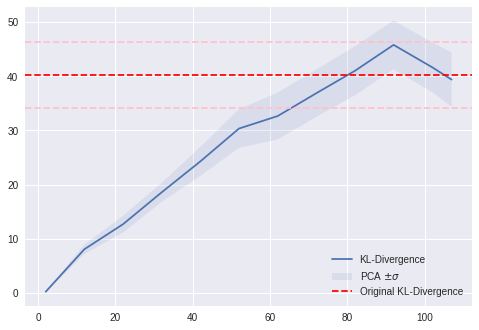

In [6]:
plt.figure()
plot_divergences(dc2_dim, dc2_div, dc2_mean, dc2_std)
plt.show()

# DC2 SNR

In [7]:
dc2_snr = DC2Generator(snr=10)

In [8]:
dc2_snr_dim, dc2_snr_mean, dc2_snr_std, dc2_snr_div = divergence_vs_dimension(dc2, dc2_snr)

  0%|          | 0/12 [00:00<?, ?it/s]

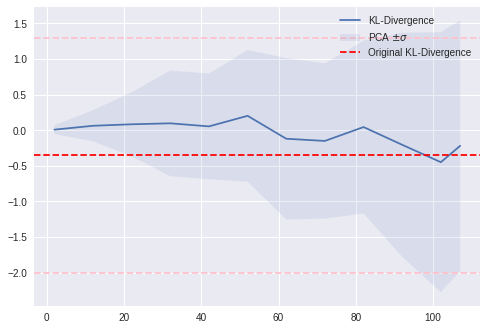

In [9]:
plt.figure()
plot_divergences(dc2_snr_dim, dc2_snr_div, dc2_snr_mean, dc2_snr_std)
plt.show()

# NMIST

In [10]:
nmist2 = NmistGenerator(2)
nmist3 = NmistGenerator(3)

In [11]:
nmist_dim, nmist_mean, nmist_std, nmist_div = divergence_vs_dimension(nmist2, nmist3)

  0%|          | 0/80 [00:00<?, ?it/s]

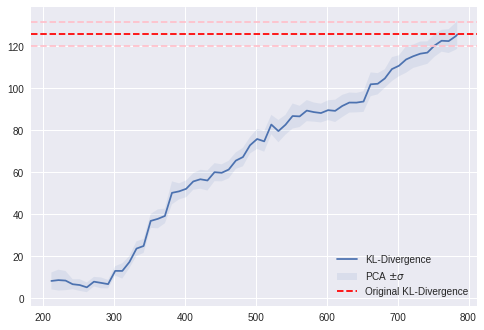

In [12]:
plt.figure()
plot_divergences(nmist_dim, nmist_div, nmist_mean, nmist_std)
plt.show()

# Normal

In [13]:
means = np.zeros(1000)
means2 = np.ones(1000)

n1 = MultivariateNormalGenerator(means, cov=np.diag(np.ones(1000)))
n2 = MultivariateNormalGenerator(means2, cov=np.diag(np.ones(1000)))

In [14]:
normal_dim, normal_mean, normal_std, normal_div = divergence_vs_dimension(n1, n2, step=50)

  0%|          | 0/21 [00:00<?, ?it/s]

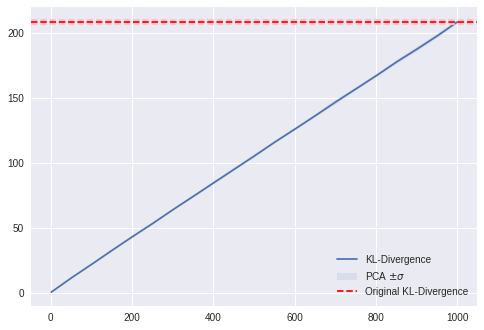

In [15]:
plt.figure()
plot_divergences(normal_dim, normal_div, normal_mean, normal_std)
plt.show()

In [16]:
means3 = np.zeros(1000)
means2[0] = 1.

n3 = MultivariateNormalGenerator(means3, cov=np.diag(np.ones(1000)))

In [17]:
_, n3_mean, n3_std, n3_div = divergence_vs_dimension(n1, n3, step=50)

  0%|          | 0/21 [00:00<?, ?it/s]

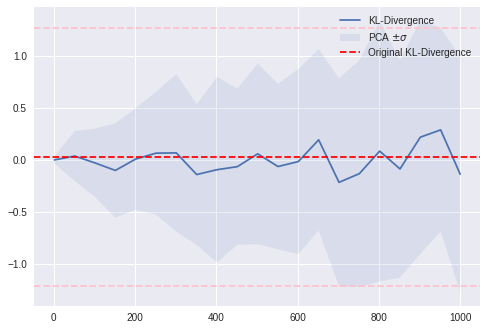

In [18]:
plt.figure()
plot_divergences(normal_dim, n3_div, n3_mean, n3_std)
plt.show()